# KNN Model

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (15, 15)

## Retrieve all of the features and labels

In [5]:
npzfile = np.load('../data/melspects.npz', allow_pickle=True)

In [8]:
X_train, y_train = npzfile['X_train'], npzfile['y_train']
X_test, y_test = npzfile['X_test'], npzfile['y_test']

## Normalize the Data

We need to reshape the data so that we can use sklearn's `StandardScaler` becasue it only works with 2D arrays. Our data is currently stored as a 3D array.

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## PCA

So currently we have 61440 features, I'm going to use PCA to reduce the dimensionality significantly.

In [13]:
X_train_sc.shape

(750, 61440)

In [43]:
pca = PCA(n_components=18)
pca.fit(X_train_sc)

X_train_reduced = pca.transform(X_train_sc)
X_test_reduced = pca.transform(X_test_sc)

In [44]:
X_train_reduced.shape

(750, 18)

So after performing PCA, only keeping 18 features. Considerably less than we started with. I found that this yielded the most accurate models when testing different values for `n_components`.

## Training the Model

I'm going to use sklearn's `GridSearchCV` for hyperparameter tuning. The two parameters I'm going to tune are the `KNeighborsClassifier`'s `n_neighbors` and `weights` parameters. The two weight options I will consider are the uniform and distance option. I'll be looking in a range of 5 to 15 for the number of neighbors.

The nice thing about `GridSearchCV` is it will perform K-Fold crossvalidation for me. By default it will use 5 folds, which is plenty.

In [45]:
parameters = {'weights':('uniform', 'distance'), 'n_neighbors': range(5, 16)}

knn = KNeighborsClassifier()

clf = GridSearchCV(knn, parameters)

In [46]:
clf.fit(X_train_reduced, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(5, 16),
                         'weights': ('uniform', 'distance')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [50]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_reduced)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'n_neighbors': 5, 'weights': 'distance'}

Grid scores on development set:

0.459 (+/-0.053) for {'n_neighbors': 5, 'weights': 'uniform'}
0.496 (+/-0.036) for {'n_neighbors': 5, 'weights': 'distance'}
0.459 (+/-0.095) for {'n_neighbors': 6, 'weights': 'uniform'}
0.480 (+/-0.035) for {'n_neighbors': 6, 'weights': 'distance'}
0.444 (+/-0.063) for {'n_neighbors': 7, 'weights': 'uniform'}
0.477 (+/-0.051) for {'n_neighbors': 7, 'weights': 'distance'}
0.448 (+/-0.034) for {'n_neighbors': 8, 'weights': 'uniform'}
0.484 (+/-0.022) for {'n_neighbors': 8, 'weights': 'distance'}
0.447 (+/-0.057) for {'n_neighbors': 9, 'weights': 'uniform'}
0.483 (+/-0.065) for {'n_neighbors': 9, 'weights': 'distance'}
0.445 (+/-0.035) for {'n_neighbors': 10, 'weights': 'uniform'}
0.473 (+/-0.025) for {'n_neighbors': 10, 'weights': 'distance'}
0.447 (+/-0.019) for {'n_neighbors': 11, 'weights': 'uniform'}
0.472 (+/-0.031) for {'n_neighbors': 11, 'weights': 'distance'

So for the KNN model the best parameter set was to use 5 for `n_neighbors` and distance for `weights`. The classification report is telling us that the overall accuracy of the model was 0.46, which is honestly better than I expected from the KNN model. The genre of music that seems to be the most problematic is 9 (rock). We are misclassifying them almost everytime, the precision is 0.15 and the recall is 0.08. The second worst genre was 3 (disco).

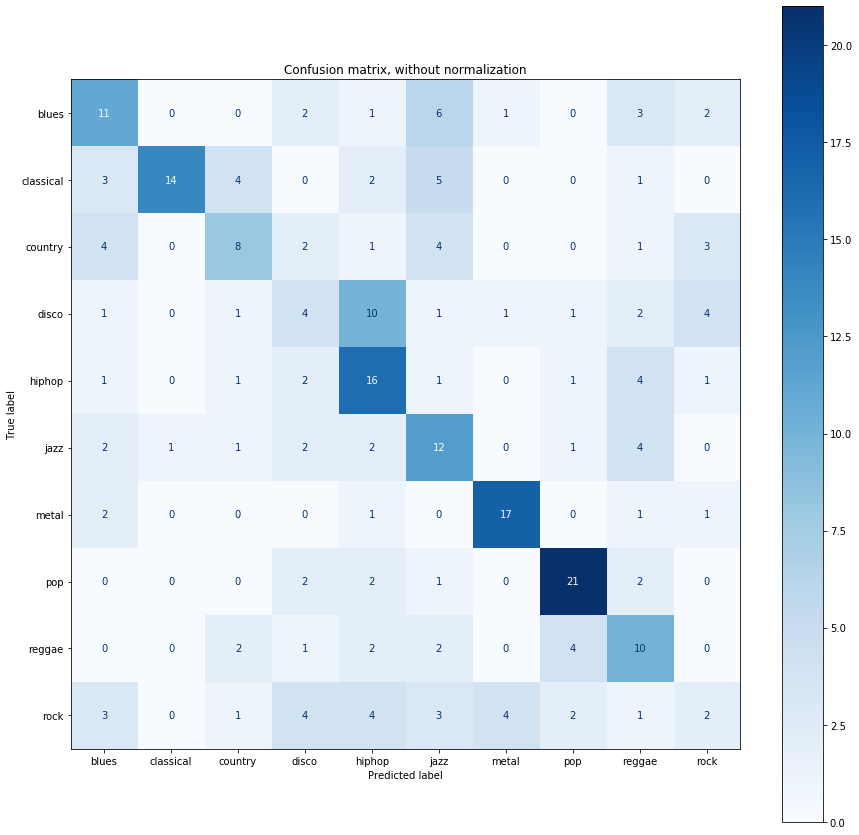

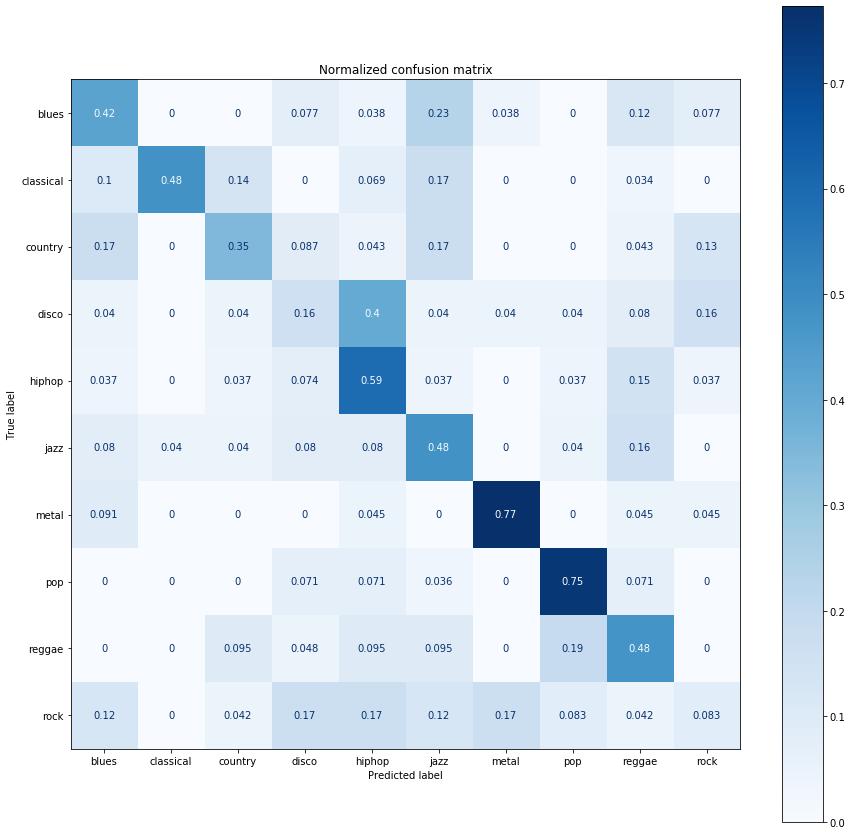

In [59]:
class_names = ['blues', 'classical', 'country', 'disco', 
               'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test_reduced, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

So the genres that were the easiest to classify were metal and pop. This makes sense becasue both those genres have very distinct sounds.